In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.linear_model import Ridge

from rich.progress import track

In [7]:
def arma(T, a, b, sigma):
    e = sigma*np.random.normal(size=T)
    for t in range(1,T):
        e[t] = a*e[t-1] + e[t]
    
    x = np.zeros(T)
    x[0] = e[0]
    for t in range(1,T):
        x[t] = b*x[t-1] + e[t]
        
    return x

In [8]:
class BarraNet(nn.Module):
    def __init__(self, n, p, k, hidden_dims=[512, 256, 128]):
        super().__init__()
        self.n = n
        self.p = p
        self.k = k
        
        # Shared MLP that processes each row independently
        layers = []
        input_dim = p  # Single row input
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
            ])
            input_dim = hidden_dim
        
        # Output produces k values per row
        layers.append(nn.Linear(input_dim, k))
        self.mlp = nn.Sequential(*layers)
    
    def g(self, beta):
        """
        Extract g(beta) - the learned transformation function
        beta: (batch, n, p)
        returns: (batch, n, k) - the transformation matrix
        """
        batch_size = beta.shape[0]
        # Reshape to process all rows at once
        beta_flat = beta.reshape(batch_size * self.n, self.p)  # (batch*n, p)
        g_flat = self.mlp(beta_flat)  # (batch*n, k)
        return g_flat.reshape(batch_size, self.n, self.k)  # (batch, n, k)
    
    def forward(self, beta, R):
        # beta: (batch, n, p)
        # R: (batch, k)
        
        # Get g(beta) as (batch, n, k) matrix
        g_beta = self.g(beta)  # (batch, n, k)
        
        # Matrix multiplication using einsum (more efficient for this case)
        r_pred = torch.einsum('bnk,bk->bn', g_beta, R)  # (batch, n)
        
        return r_pred

## Build data

In [24]:
%%time

T = 25
n = 1000
p = 20

## set seed
np.random.seed(56)

## set beta[t]
beta = np.zeros((T,n,p))
for i in range(n):
    for j in range(p):
        beta[:,i,j] = arma(T, a=0.95, b=0.95, sigma=0.025)

for t in range(T):
    for j in range(p):
        beta[t,:,j] = (beta[t,:,j] - beta[t,:,j].mean()) / beta[t,:,j].std()

## R[t] and e[t]
R = np.random.randn(T,p)
e = np.random.randn(T,n)

r = np.zeros((T,n))
r_expl = np.zeros((T,n))
for t in range(T):
    r[t] = beta[t] @ R[t] + 5*e[t]
    r_expl[t] = beta[t] @ R[t]

rho_expl = np.zeros(T)
for t in range(T):
    rho_expl[t] = np.corrcoef(r[t], r_expl[t])[0,1]
rho_expl_avg = np.mean(rho_expl)
print(rho_expl_avg)

0.5054193590288931
CPU times: user 126 ms, sys: 10.9 ms, total: 136 ms
Wall time: 126 ms


In [32]:
device = "cpu"

## model dimension
k = 20

# Convert your data to tensors
r_data = torch.from_numpy(r).float().to(device)
beta_data = torch.from_numpy(beta).float().to(device)

## nb_iter
nb_iter = 100

rho_avg = np.zeros(nb_iter)

## Initialize S_hat
S_hat = np.random.randn(T,k)
S_data = torch.from_numpy(S_hat).float().to(device)

for l in track(range(nb_iter)):

    # Create model
    model = BarraNet(n, p, k, hidden_dims=[128, 64]).to(device)
    
    ## Optim
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Training loop (unchanged)
    batch_size = 20
    num_epochs = 50
    
    for epoch in range(num_epochs):
        indices = torch.randperm(T)
        total_loss = 0
        
        for i in range(0, T, batch_size):
            batch_idx = indices[i:i+batch_size]
            
            beta_batch = beta_data[batch_idx]
            S_batch = S_data[batch_idx]
            r_batch = r_data[batch_idx]
            
            # Forward pass
            r_pred = model(beta_batch, S_batch)
            loss = criterion(r_pred, r_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        g_beta = model.g(beta_data)
        r_pred = model(beta_data, S_data)

    g_beta_np = g_beta.cpu().detach().numpy()
    r_np = r_data.cpu().numpy()
    r_pred_np = r_pred.cpu().numpy()
    
    rho = np.zeros(T)
    for t in range(T):
        rho[t] = np.corrcoef(r[t], r_pred_np[t])[0,1]
    rho_avg[l] = np.mean(rho)
    
    S_hat = np.array([Ridge(alpha=0., fit_intercept=False).fit(g_beta_np[t], r_np[t]).coef_ for t in range(len(r_data))])
    S_data = torch.from_numpy(S_hat).float().to(device)    

Output()

In [33]:
g_beta_np.shape

(25, 1000, 20)

Text(0.5, 1.0, 'Alternate NN with Ridge\n')

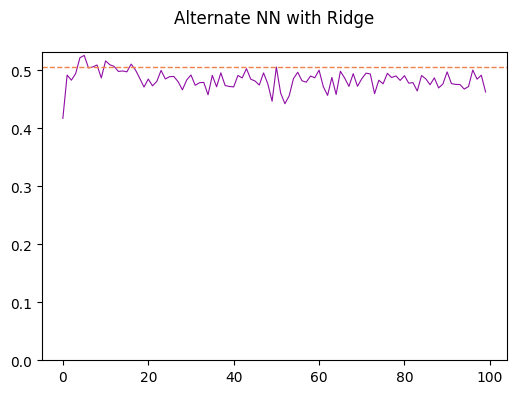

In [34]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(nb_iter), rho_avg, color=cm.plasma(0.3), lw=0.8)
ax.axhline(y=rho_expl_avg, color=cm.plasma(0.7), lw=1., linestyle="dashed")
ax.set_ylim([0, None])
ax.set_title("Alternate NN with Ridge\n")